# STORYLINES CONSTRUCTION
Validation of models and visualization of indices

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import glob
import importlib

import function_storylines as funsl

### PARAMETERS, DIRECTORIES AND METADATA

In [82]:
## PARAMETERS

### Region on which HW Storylines are calculated
### PoValley is already available (it considers the gridpoints covered by the Italian regions of Piedmont, Lombardy, Veneto and Emilia Romagna)
region = 'PoValley'

### Indices are calculated considering the summer months of June, July and August (JJA)
months_code = 'JJA'

### Method of the Common Warming States (CWS)
### In all CMIP6 models and in ERA5 the anomalies and the indices are calculate with respect to the 30-year-long period in which that model has a 
### Global Surface Air Temperature (GSAT) of 14.2°C, hence "CWS142". This corresponds to the average GSAT of ERA5 in the period 1981-2010. 
### Indices in the future can be calculated on periods with GSAT 15°C (CWS15) or 17.5°C (CWS175)
CWS_ref = 'CWS142'
CWS_warm = 'CWS15'

wmgs = [CWS_ref, CWS_warm]

### Variables used as candidate predictors
variables = ['tmax','mslp','z500','tp','sm','sst','sic','olr']

### CMIP6 models, members and ssp to be included

models_all = ['ACCESS-CM2','AWI-CM-1-1-MR','BCC-CSM2-MR','CAMS-CSM1-0',
    'CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-CM6-1-HR',
    'EC-Earth3','GFDL-CM4','HadGEM3-GC31-MM','INM-CM4-8',
    'KACE-1-0-G','MIROC6','MPI-ESM1-2-HR','MRI-ESM2-0',
    'NorESM2-MM','UKESM1-0-LL'] ## all available models

# models = ['ACCESS-CM2','CMCC-ESM2',
#     'EC-Earth3','GFDL-CM4',
#     'MPI-ESM1-2-HR','MRI-ESM2-0',
#     'UKESM1-0-LL'] ## which models to use

models = models_all
members = [0] ## which members to use (0 to use them all, 1 if you want to use only member 1, etc.)
ssps = ['ssp245'] ## which ssp to use

### Experiment code related to this example (for internal use)
### cl105: Heatwaves in PoValley, JJA
### cl205: Heatwaves in Southern Argentina, DJF
exp_code_in = 'cl105' ##fundamental to get input data, do not change
exp_code_out = 'cl305' ##name of the experiment for the outputs

### Overwrite previous results?
overwrite = False

In [3]:
### THRESHOLDS

### Thresholds used for the selection of drivers in ERA5 and CMIP6
### E.g. Which fraction of the top evaluations should indicate a candidate in order
### to select it as a driver?
thre_ERA5 = 0.67 #threshold for lag-dependent selection of drivers in ERA5
thre_CMIP6 = 0.5 #threshold for lag-dependent of drivers in CMIP6 models

### The validation of CMIP6 models with respect to the results on ERA5 is performed in multiple steps.
### The Feature Selection is performed on three different statistics (mean, pc25 and pc75).
### With these thresholds\the system chooses which statistics to use for each selected drivers
### Contact antonello.squintu@cmcc.it for more details
thre_CMIP6_sel = 0.5 
thre_CMIP6_low = 0.33 

tolerance = 0.05 ## tolerance level for scores below the thresholds

min_pop_pair = 10 ## minimum number of simulations to start the storyline construction
min_pop_sl = 3 ## minimum number of simulations to "activate" a storyline

In [89]:
## DIRECTORIES

metadata_path = "/home/b/b382649/feat-sel-CMIP6/ASQ_scripts/"
output_path = "./StorylinesOutputs/"
FSRes_path="/work/bk1318/b382649/Summary_feat-sel/" ##Where to find results of Feature Selection
series_path = '/work/bk1318/b382649/CMIP6/' ## Where to find data to calculate projections

### Where to find the masks that give the names to the candidate predictors
maskdir = f'/home/b/b382649/feat-sel-CMIP6/Predictors/Test_{exp_code_in}_low/labels/'

In [5]:
## READING METADATA

###Variables

## Specifications of variables
varspecs = pd.read_csv(f"{metadata_path}varspecs.csv")
varspecs = varspecs[~varspecs['name'].isin(['enso34', 'gsat'])] #exclude these variables (used in other experiments)

## Acronyms to use for the selected drivers
acronyms_drivers = pd.read_csv(f"{metadata_path}acronym_drivers_{exp_code_in}_{region}_{months_code}_{CWS_ref}.csv",index_col=None)

## Names and specifications of different CWS
warmingspecs = pd.DataFrame([{'name':'CWS142',
                  'name4plots': 'CWS 14.2',
                  'type': 'CWS'},
                            {'name':'CWS150',
                  'name4plots': 'CWS 15',
                  'type': 'CWS'},
                            {'name':'CWS175',
                  'name4plots': 'CWS 17.5',
                  'type': 'CWS'}])
warmingspecs.set_index('name', inplace=True)
cws4plot = warmingspecs.loc[CWS_ref,'name4plots'] ##CWS to write in the plots titles


### Models

## Dataframe with the CWS of all models
CWS_models = pd.read_csv(f"{metadata_path}CWS_all_models.csv")


## Generate list of CMIP6 models that have been tested (testnames)
listfile = f"{metadata_path}CLINT155_all_testnames_{exp_code_in}_{region}_{months_code}.txt"
with open(listfile, 'r') as openfile:
    lines = openfile.readlines()
testnames = [line.strip() for line in lines if CWS_ref in line] ## select those that match the selected cws

In [6]:
#testnames

In [7]:
models

['ACCESS-CM2',
 'AWI-CM-1-1-MR',
 'BCC-CSM2-MR',
 'CAMS-CSM1-0',
 'CMCC-CM2-SR5',
 'CMCC-ESM2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'EC-Earth3',
 'GFDL-CM4',
 'HadGEM3-GC31-MM',
 'INM-CM4-8',
 'KACE-1-0-G',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MRI-ESM2-0',
 'NorESM2-MM',
 'UKESM1-0-LL']

In [8]:
### FILTER TESTNAME LIST

testnames = [testname for testname in testnames if any(model in testname for model in models)] ## match with the indicated models
if 0 not in members: 
    testnames = [testname for testname in testnames if any(f'mmb{str(member).zfill(2)}' in testname for member in members)] ## match with the indicated members
testnames = [testname for testname in testnames if any(ssp in testname for ssp in ssps)] ## match with the indicated ssps



## List of CMIP6 simulations where the list of predictors is different among ssp scenarios
## (when the predictors are the same the Feature Selection can be run once on one of the ssp)
with open(f"{metadata_path}CLINT147_exception_fullnames.txt", "r") as file:
    # Read lines into a list
    exception_fullnames = [line.strip() for line in file]
    
## List of CMIP6 simulations that for various reasons (e.g. corrupted files or problems in the timeline) 
## must be excluded from the analysis)
with open(f"{metadata_path}CLINT148_skip_testnames.txt", "r") as file:
    # Read lines into a list
    skip_testnames = [line.strip() for line in file]
testnames = [testname  for testname in testnames if testname not in skip_testnames] ## remove them

In [9]:
testnames

['ACCESS-CM2_mmb01_ssp245_CWS142',
 'ACCESS-CM2_mmb02_ssp245_CWS142',
 'ACCESS-CM2_mmb03_ssp245_CWS142',
 'AWI-CM-1-1-MR_mmb01_ssp245_CWS142',
 'CAMS-CSM1-0_mmb02_ssp245_CWS142',
 'CMCC-CM2-SR5_mmb02_ssp245_CWS142',
 'CMCC-ESM2_mmb01_ssp245_CWS142',
 'CNRM-CM6-1_mmb01_ssp245_CWS142',
 'EC-Earth3_mmb01_ssp245_CWS142',
 'EC-Earth3_mmb04_ssp245_CWS142',
 'EC-Earth3_mmb06_ssp245_CWS142',
 'EC-Earth3_mmb07_ssp245_CWS142',
 'EC-Earth3_mmb09_ssp245_CWS142',
 'EC-Earth3_mmb11_ssp245_CWS142',
 'EC-Earth3_mmb13_ssp245_CWS142',
 'EC-Earth3_mmb14_ssp245_CWS142',
 'EC-Earth3_mmb15_ssp245_CWS142',
 'EC-Earth3_mmb16_ssp245_CWS142',
 'EC-Earth3_mmb17_ssp245_CWS142',
 'EC-Earth3_mmb18_ssp245_CWS142',
 'EC-Earth3_mmb19_ssp245_CWS142',
 'EC-Earth3_mmb21_ssp245_CWS142',
 'EC-Earth3_mmb22_ssp245_CWS142',
 'EC-Earth3_mmb23_ssp245_CWS142',
 'EC-Earth3_mmb24_ssp245_CWS142',
 'EC-Earth3_mmb25_ssp245_CWS142',
 'GFDL-CM4_mmb01_ssp245_CWS142',
 'INM-CM4-8_mmb01_ssp245_CWS142',
 'KACE-1-0-G_mmb01_ssp245_CWS142',
 

In [10]:
## INITIATE OUTPUTS 

sl_df_filename = f"{output_path}storylines_df_{exp_code_out}_{region}_{months_code}_{CWS_warm}.csv"
board_df_filename = f"{output_path}boarddf_{exp_code_out}_{region}_{months_code}_{CWS_warm}.csv"
selrate_df_filename = f"{output_path}selratedf_{exp_code_out}_{region}_{months_code}_{CWS_warm}.csv"

if ((os.path.exists(sl_df_filename)) & (not overwrite)):
    sl_df = pd.read_csv(sl_df_filename) #upload the existing one|
else:
    sl_df = pd.DataFrame(columns = ['number','first_dr','second_dr','first_dr_cl','first_dr_stat','second_dr_cl','second_dr_stat',]) #create a new one


### VALIDATION OF CMIP6 SIMULATIONS TO BE USED FOR THE STORYLINES

In [11]:

### Identification of those CMIP6 simulations that share same CWS142 (FS was run only once in their historical period, 'hist')

skip_model = 'nothing_yet'
skip_mmb = 'nothing_yet'
for testname in testnames:

    fullname = testname.rsplit('_', 1)[0] ## fullname is the testname without the cws indication

    ## if the CWS142 of this testname ends after 2015 or if it is in the exceptions, do nothing
    if ((CWS_models.loc[CWS_models.full_name == fullname, f'{CWS_ref}_stop'].values >= 2015) | 
       (fullname in exception_fullnames)):
        skip_model = 'nothing_again'
        skip_mmb = 'nothing_again'
    else: # in the other cases
        if ((CWS_models.loc[CWS_models.full_name == fullname, 'model'].values[0] is not skip_model) |
           (CWS_models.loc[CWS_models.full_name == fullname, 'member'].values[0] != skip_mmb)):

            ### Memorize the name of the model and of the member that shares same CWS142 with other ssp
            skip_model = CWS_models.loc[CWS_models.full_name == fullname, 'model'].values[0]
            skip_mmb = CWS_models.loc[CWS_models.full_name == fullname, 'member'].values[0]
            
            ### Replace the name of ssp with 'hist'
            parts = testname.split('_')
            new_testname = '_'.join(parts[:2] + ['hist'] + parts[3:])   ## replace ssp with hist

            ### Replace the in the list of testnames
            testnames[testnames.index(testname)] = new_testname            
        else:
            ### This testname has same model and member name as one that has been already stored in the list
            testnames[testnames.index(testname)] = 'drop'

testnames = [t for t in testnames if t != 'drop']

In [12]:
### Add ERA5 (benchmark dataset)
if 'ERA5_mmb01_reanalysis_CWS142' not in testnames:
    testnames = np.append(['ERA5_mmb01_reanalysis_CWS142'], testnames)

In [13]:
testnames

array(['ERA5_mmb01_reanalysis_CWS142', 'ACCESS-CM2_mmb01_ssp245_CWS142',
       'ACCESS-CM2_mmb02_hist_CWS142', 'ACCESS-CM2_mmb03_hist_CWS142',
       'AWI-CM-1-1-MR_mmb01_hist_CWS142', 'CAMS-CSM1-0_mmb02_hist_CWS142',
       'CMCC-CM2-SR5_mmb02_hist_CWS142', 'CMCC-ESM2_mmb01_hist_CWS142',
       'CNRM-CM6-1_mmb01_ssp245_CWS142', 'EC-Earth3_mmb01_hist_CWS142',
       'EC-Earth3_mmb04_hist_CWS142', 'EC-Earth3_mmb06_hist_CWS142',
       'EC-Earth3_mmb07_hist_CWS142', 'EC-Earth3_mmb09_hist_CWS142',
       'EC-Earth3_mmb11_hist_CWS142', 'EC-Earth3_mmb13_hist_CWS142',
       'EC-Earth3_mmb14_hist_CWS142', 'EC-Earth3_mmb15_hist_CWS142',
       'EC-Earth3_mmb16_hist_CWS142', 'EC-Earth3_mmb17_hist_CWS142',
       'EC-Earth3_mmb18_hist_CWS142', 'EC-Earth3_mmb19_hist_CWS142',
       'EC-Earth3_mmb21_hist_CWS142', 'EC-Earth3_mmb22_hist_CWS142',
       'EC-Earth3_mmb23_hist_CWS142', 'EC-Earth3_mmb24_hist_CWS142',
       'EC-Earth3_mmb25_hist_CWS142', 'GFDL-CM4_mmb01_ssp245_CWS142',
       'INM-CM4

In [14]:
### Dataframe to check which drivers are selected for each testname
sel_drivers = pd.DataFrame(index=testnames)

### Generate columns of the dataframe according to which candidate predictors have been considerd
for var in variables:
    #print(var)
    var_CMIP6 = varspecs.loc[varspecs.name==var,'CMIP6'].values[0]

    var_name_masks = var  
    mask_generic = f"{maskdir}{exp_code_in}_stwpcakm005-000_?low_{var}_*.csv"
    mask_files = glob.glob(mask_generic)

    ### Guess the name of the domain from the name of the mask
    for mask_file in mask_files:
        if "Europe" in mask_file :
            domain = 'Europe'
        elif "World" in mask_file :
            domain = 'World'    
        elif "Artic" in mask_file :
            domain = 'Artic'
        elif "North_Atlantic" in mask_file :
            domain = 'North_Atlantic'
        elif "NorthAtlantic" in mask_file :
            domain = 'NorthAtlantic'
        elif "Mediterranean" in mask_file :
            domain = 'Mediterranean'
        elif "Arctic" in mask_file :
            domain = 'Arctic'                                                    
        elif "Tropics" in mask_file :
            domain = 'Tropics'
        else:
            print(mask_file)
            print('!!!DOMAIN NOT FOUND!!!')
        if ((var == 'olr') and (domain == 'World')):
            ### Skip this domain
            continue
            
        dummy_mask_df = pd.read_csv(mask_file,index_col=[0])
        cl_nrs = np.unique(dummy_mask_df.cluster) #get the name and number of the clusters
        
        for cl in cl_nrs:
            column_names = [
                f'{var_CMIP6}_{domain}_cllow{str(cl).zfill(2)}_mean',
                f'{var_CMIP6}_{domain}_cllow{str(cl).zfill(2)}_pc25',
                f'{var_CMIP6}_{domain}_cllow{str(cl).zfill(2)}_pc75']
            #print(column_names)
            new_columns = pd.DataFrame(index=testnames, columns=column_names)
            sel_drivers = pd.concat([sel_drivers, new_columns], axis=1)

In [15]:
sel_drivers

,tasmax_Europe_cllow00_mean,tasmax_Europe_cllow00_pc25,tasmax_Europe_cllow00_pc75,tasmax_Europe_cllow01_mean,tasmax_Europe_cllow01_pc25,tasmax_Europe_cllow01_pc75,tasmax_Europe_cllow02_mean,tasmax_Europe_cllow02_pc25,tasmax_Europe_cllow02_pc75,tasmax_Europe_cllow03_mean,...,rlut_NorthAtlantic_cllow01_pc75,rlut_NorthAtlantic_cllow02_mean,rlut_NorthAtlantic_cllow02_pc25,rlut_NorthAtlantic_cllow02_pc75,rlut_NorthAtlantic_cllow03_mean,rlut_NorthAtlantic_cllow03_pc25,rlut_NorthAtlantic_cllow03_pc75,rlut_NorthAtlantic_cllow04_mean,rlut_NorthAtlantic_cllow04_pc25,rlut_NorthAtlantic_cllow04_pc75
ERA5_mmb01_reanalysis_CWS142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACCESS-CM2_mmb01_ssp245_CWS142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACCESS-CM2_mmb02_hist_CWS142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACCESS-CM2_mmb03_hist_CWS142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AWI-CM-1-1-MR_mmb01_hist_CWS142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CAMS-CSM1-0_mmb02_hist_CWS142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CMCC-CM2-SR5_mmb02_hist_CWS142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CMCC-ESM2_mmb01_hist_CWS142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CNRM-CM6-1_mmb01_ssp245_CWS142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EC-Earth3_mmb01_hist_CWS142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
### Prepare dataframes (boards) for reading FS results 

board_df = sel_drivers.copy()
selrate_df = sel_drivers.copy()
ordercolumns = np.array(sel_drivers.columns) 

In [17]:
### Fill the boards

for testname in testnames:
    print(testname)
    if testname == 'ERA5_mmb01_hist_CWS142':
        boardfile = (f'{FSRes_path}/board100_{exp_code_in}_ERA5_mmb01_reanalysis_CWS142_{region}_{months_code}.csv')
        selratefile = f"{FSRes_path}selected_drivers_{exp_code_in}_ERA5_mmb01_reanalysis_CWS142_{region}_{months_code}.csv"
    else:
        boardfile = f'{FSRes_path}board100_{exp_code_in}_{testname}_{region}_{months_code}.csv'
        selratefile = f"{FSRes_path}selected_drivers_{exp_code_in}_{testname}_{region}_{months_code}.csv"

    if os.path.exists(boardfile):
        board_df_in = pd.read_csv(f'{boardfile}',index_col=[0])
        rolling_board = board_df_in.rolling(window=7).mean() #calculate a rolling mean to find drivers that have relevant results for at least 7 days
        boardmax = rolling_board.max(axis=0)
        for driver in board_df_in.columns:
            driver0 = driver
            if ('tas_' in driver0):
                driver = driver.replace('tas_', 'tasmax_')
            if ('swvl1_' in driver0): ### swvl1 is soil moisture for ERA5, need to give it the same name as soil moisture in CMIP6
                driver = driver.replace('swvl1_', 'mrsos_')
            board_df.loc[testname,driver] = float(boardmax[driver0])
        boardmax = board_df_in.max(axis=0)
    else:
        print(f'{boardfile}          does not exist')
    
    if os.path.exists(selratefile):
        selrate_df_in = pd.read_csv(f'{selratefile}',index_col=[0])    
   
        for driver in selrate_df_in.index:
            driver0 = driver
            if ('tas_' in driver0):
                driver = driver.replace('tas_', 'tasmax_')
            if ('swvl1_' in driver0):
                driver = driver.replace('swvl1_', 'mrsos_')
            for stat in ('mean','pc25','pc75'):
                selrate_df.loc[testname,f'{driver}_{stat}'] = int(selrate_df_in.loc[driver0,'sel_by_not_discarded'])
    else:
        print(f'{selratefile}          does not exist')

ERA5_mmb01_reanalysis_CWS142
ACCESS-CM2_mmb01_ssp245_CWS142
ACCESS-CM2_mmb02_hist_CWS142
ACCESS-CM2_mmb03_hist_CWS142
AWI-CM-1-1-MR_mmb01_hist_CWS142
CAMS-CSM1-0_mmb02_hist_CWS142
CMCC-CM2-SR5_mmb02_hist_CWS142
CMCC-ESM2_mmb01_hist_CWS142
CNRM-CM6-1_mmb01_ssp245_CWS142
EC-Earth3_mmb01_hist_CWS142
EC-Earth3_mmb04_hist_CWS142
EC-Earth3_mmb06_hist_CWS142
EC-Earth3_mmb07_hist_CWS142
EC-Earth3_mmb09_hist_CWS142
EC-Earth3_mmb11_hist_CWS142
EC-Earth3_mmb13_hist_CWS142
EC-Earth3_mmb14_hist_CWS142
EC-Earth3_mmb15_hist_CWS142
EC-Earth3_mmb16_hist_CWS142
EC-Earth3_mmb17_hist_CWS142
EC-Earth3_mmb18_hist_CWS142
EC-Earth3_mmb19_hist_CWS142
EC-Earth3_mmb21_hist_CWS142
EC-Earth3_mmb22_hist_CWS142
EC-Earth3_mmb23_hist_CWS142
EC-Earth3_mmb24_hist_CWS142
EC-Earth3_mmb25_hist_CWS142
GFDL-CM4_mmb01_ssp245_CWS142
INM-CM4-8_mmb01_ssp245_CWS142
KACE-1-0-G_mmb01_ssp245_CWS142
KACE-1-0-G_mmb02_ssp245_CWS142
MPI-ESM1-2-HR_mmb01_hist_CWS142
MPI-ESM1-2-HR_mmb02_hist_CWS142
MRI-ESM2-0_mmb01_hist_CWS142
NorESM2-MM_m

In [18]:
board_df

,tasmax_Europe_cllow00_mean,tasmax_Europe_cllow00_pc25,tasmax_Europe_cllow00_pc75,tasmax_Europe_cllow01_mean,tasmax_Europe_cllow01_pc25,tasmax_Europe_cllow01_pc75,tasmax_Europe_cllow02_mean,tasmax_Europe_cllow02_pc25,tasmax_Europe_cllow02_pc75,tasmax_Europe_cllow03_mean,...,rlut_NorthAtlantic_cllow01_pc75,rlut_NorthAtlantic_cllow02_mean,rlut_NorthAtlantic_cllow02_pc25,rlut_NorthAtlantic_cllow02_pc75,rlut_NorthAtlantic_cllow03_mean,rlut_NorthAtlantic_cllow03_pc25,rlut_NorthAtlantic_cllow03_pc75,rlut_NorthAtlantic_cllow04_mean,rlut_NorthAtlantic_cllow04_pc25,rlut_NorthAtlantic_cllow04_pc75
ERA5_mmb01_reanalysis_CWS142,0.9167,0.706471,0.4253,0.324843,0.4145,0.606786,0.619057,0.4844,0.535157,1.0,...,0.216857,0.2898,0.2265,0.479029,0.417429,0.5167,0.4368,0.210929,0.317029,0.212857
ACCESS-CM2_mmb01_ssp245_CWS142,0.804214,0.6134,0.870986,0.520243,0.501,0.527229,0.624057,0.392314,0.609686,0.4377,...,0.4452,0.586514,0.593557,0.570271,0.489214,0.278643,0.627143,0.108829,0.267229,0.399829
ACCESS-CM2_mmb02_hist_CWS142,0.898771,0.517729,0.593071,0.796786,0.297529,0.652171,0.472014,0.352214,0.434386,0.912743,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACCESS-CM2_mmb03_hist_CWS142,0.578271,0.283243,0.930443,0.544114,0.745371,0.715643,0.328014,0.5652,0.478843,0.891271,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AWI-CM-1-1-MR_mmb01_hist_CWS142,0.5578,0.572014,0.323243,0.231457,0.2713,0.432529,0.397057,0.924886,0.370286,0.800129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CAMS-CSM1-0_mmb02_hist_CWS142,0.713786,0.826986,0.995857,0.305229,0.308057,0.123,0.541471,0.3009,0.610343,0.6241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CMCC-CM2-SR5_mmb02_hist_CWS142,0.687686,0.7109,0.663214,0.728914,0.294129,0.388886,0.233843,0.641886,0.432543,0.989814,...,0.506229,0.837943,0.585386,0.928657,0.376757,0.331671,0.149886,0.253671,0.423957,0.579486
CMCC-ESM2_mmb01_hist_CWS142,0.537557,0.4085,0.452543,0.332514,0.235857,0.311629,0.527043,0.638343,0.8759,0.629957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CNRM-CM6-1_mmb01_ssp245_CWS142,0.866943,0.764743,0.888371,0.921614,0.8701,0.546029,0.321786,0.870643,0.4785,0.443886,...,0.449386,0.484271,0.334457,0.320714,0.779014,0.767329,0.545029,0.312186,0.534771,0.7836
EC-Earth3_mmb01_hist_CWS142,0.995957,0.966129,0.603757,0.414443,0.333371,0.790314,0.389229,0.865629,0.454314,0.515357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
### Prepare the dataframe to be plotted as a heatmap

board_df = board_df[ordercolumns]
selrate_df = selrate_df[ordercolumns] ## restore the original order

if board_df.index.values[0] in ['ERA5_hist','ERA5_mmb01_hist_CWS142','ERA5_mmb01_reanalysis_CWS142']: ## replace index name in board_df
    new_index = list(board_df.index)
    new_index[0] = 'ERA5_1981/2010'
    board_df.index = new_index

if board_df.index.values[0] in ['ERA5_hist','ERA5_1981/2010']: ## make it negative for plotting reasons (different palette)
    board_df.iloc[0] = -board_df.iloc[0]

if selrate_df.index.values[0] in ['ERA5_hist','ERA5_mmb01_hist_CWS142','ERA5_mmb01_reanalysis_CWS142']: ## replace index name in selrate_df
    new_index = list(selrate_df.index)
    new_index[0] = 'ERA5_1981/2010'
    selrate_df.index = new_index

### Save the dataframes
board_df.to_csv(board_df_filename)
selrate_df.to_csv(selrate_df_filename)

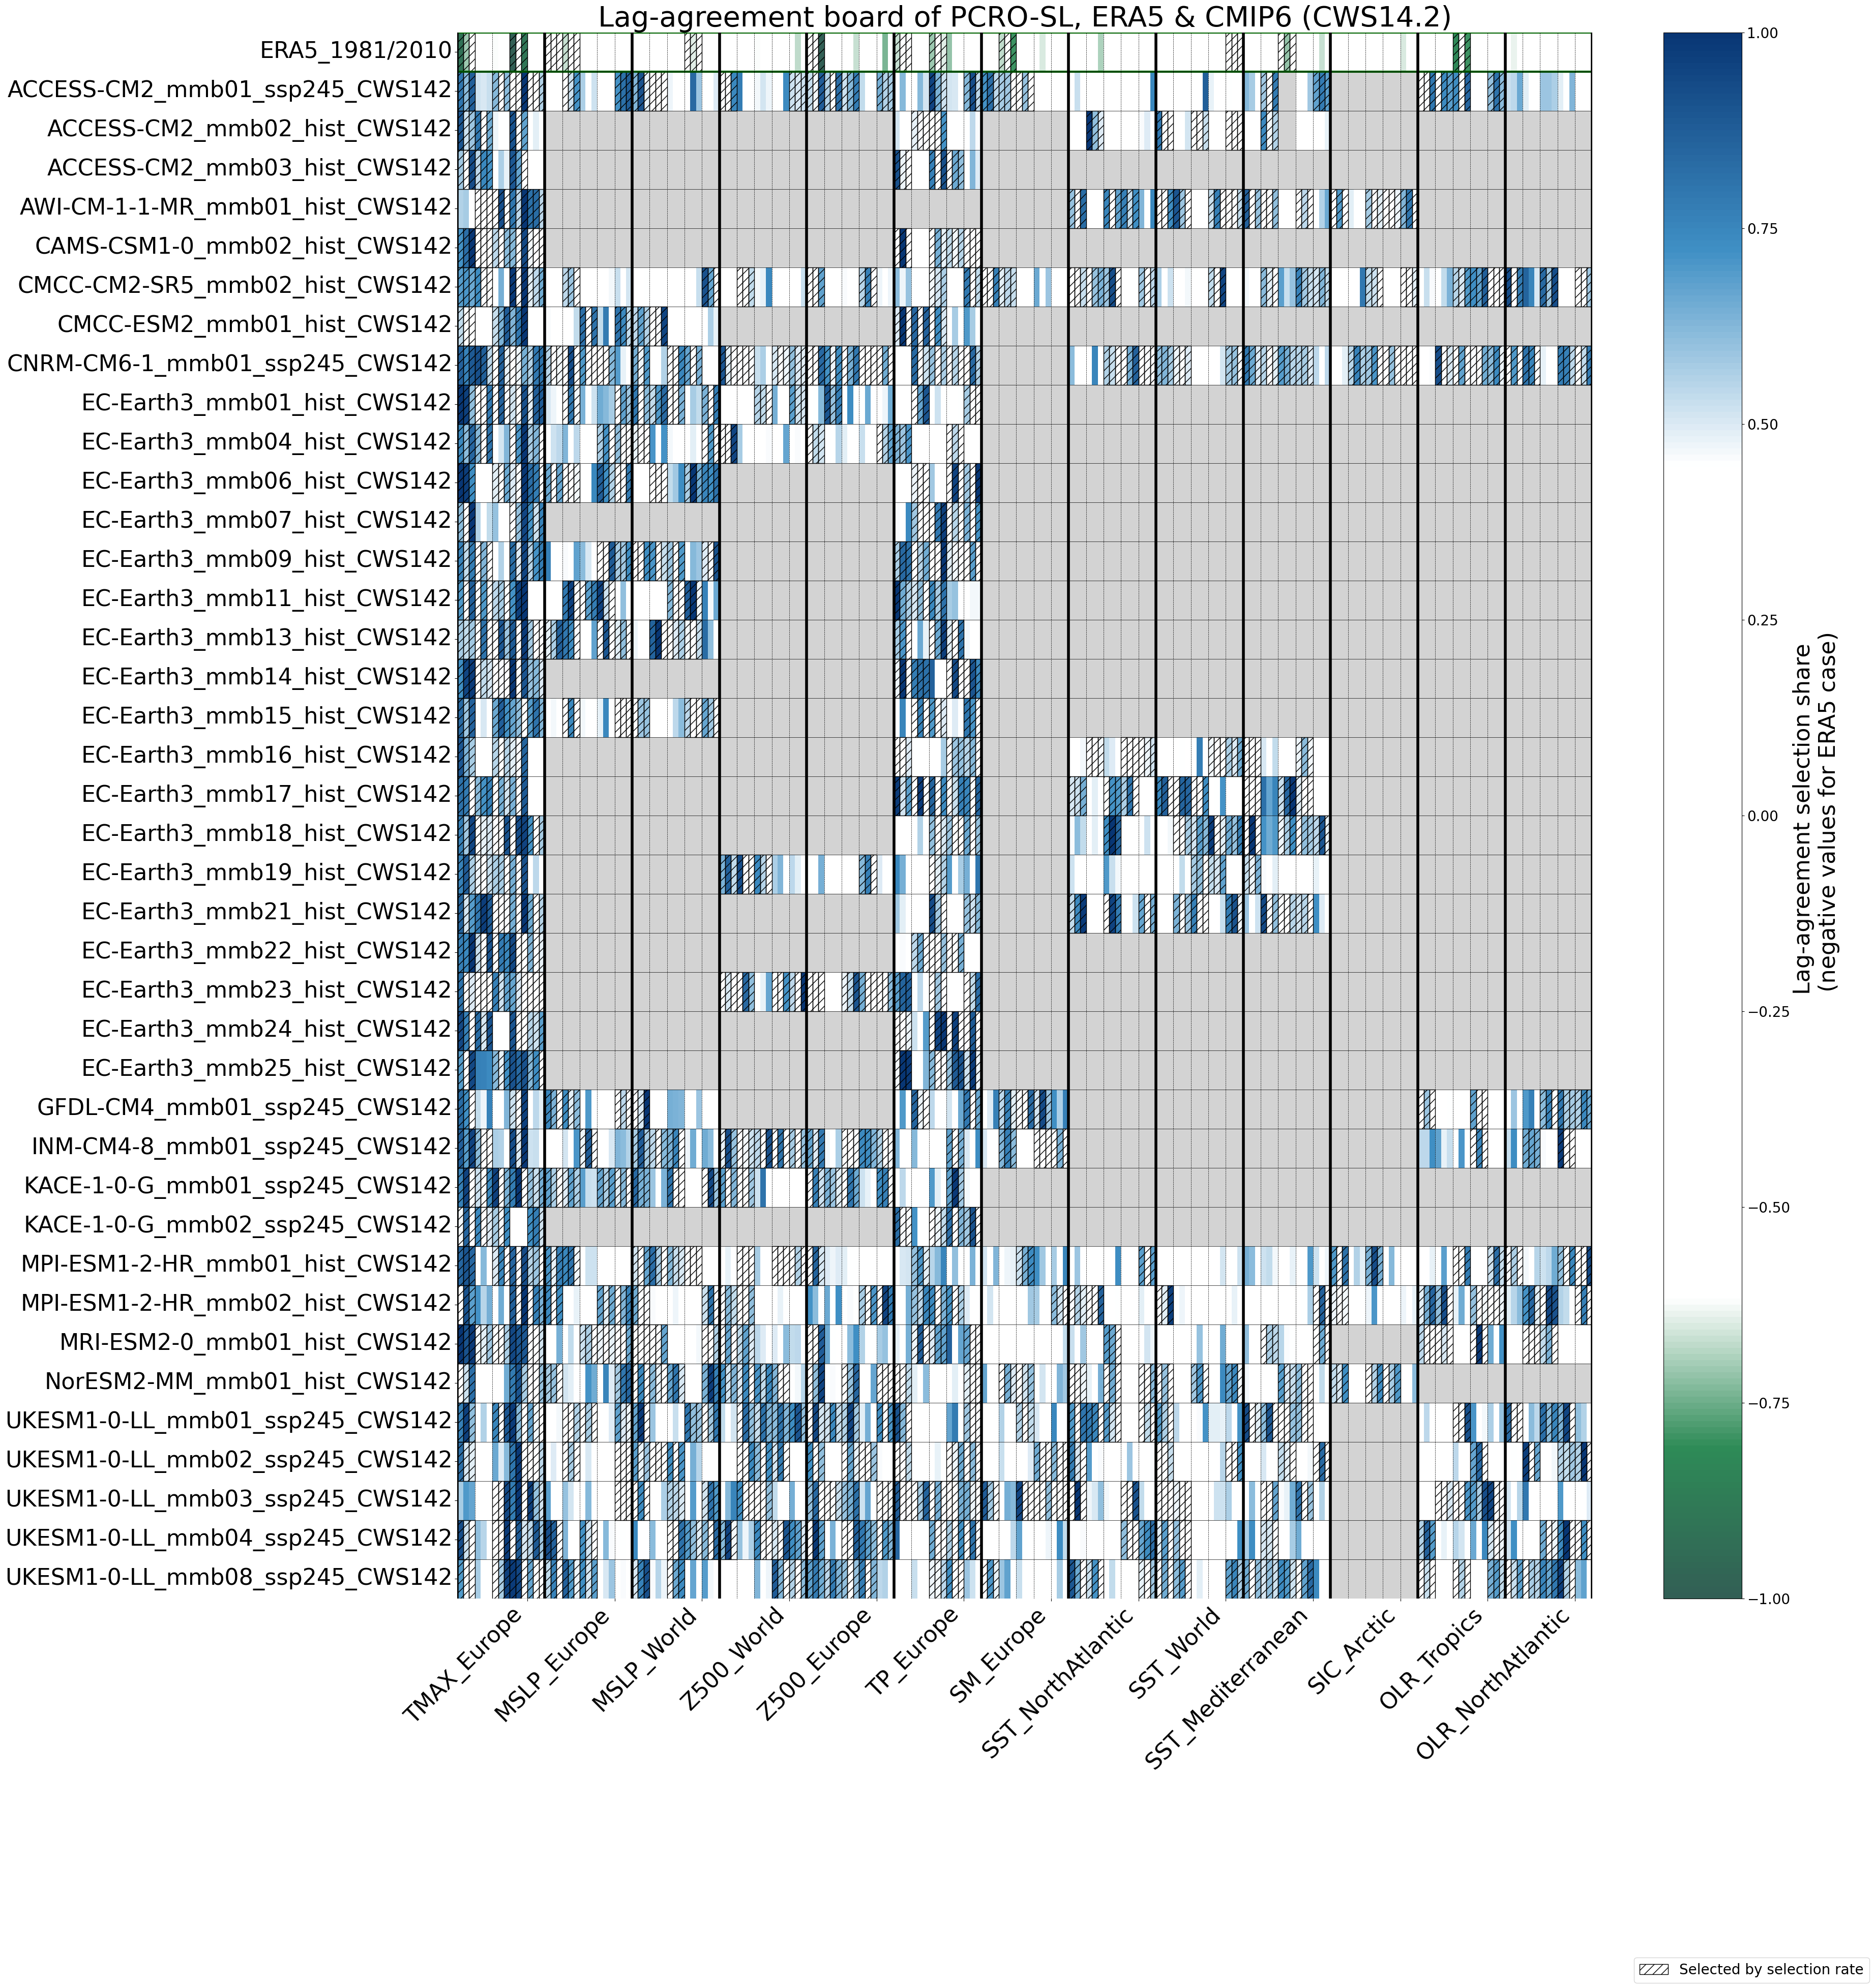

In [20]:
### HEATMAP OF LAG-AGREEMENT AND SELECTION OF DRIVERS FOR THE CMIP6 MODELS

pairs_sel = None ## if not None it prints transparent purple columns on the indicated drivers

## Green color for ERA5 to distinguish from the other ones
## Thick lines divide domains (e.g. TMAX_Europe)
## Thin lines identify clusters and range from 0 to 4
## For each cluster three summary statistics have been inspected (mean, pc25, pc75)
## Each cell identified by the thin lines has three sub-cells, one for each statistics
## If the cluster is selected with the Selection Rate (which is not dependent on lag-agreement)
##     a patch is plotted on top of the three cells
## A driver is considered selected if it at least one of the three statistics or the selection rate
##     exceeded the corresponding threshold (i.e. it is coloured or it has a patch)

funsl.board_drivers(board_df,selrate_df,pairs_sel,
                    tolerance,thre_ERA5,thre_CMIP6,region,
                    months_code,CWS_ref,varspecs,output_path)

In [21]:
### DETERMINE HOW MANY VALIDATED MODELS FOR EACH PAIR OF ERA5-SELECTED DRIVERS

pairs_table,pairs_table_or = funsl.create_pairs_table_board_selrate(board_df,selrate_df,thre_ERA5,
                                                                          thre_CMIP6)

## pairs_table has results of both lag-agreement and selection rate
##        upper triangle (above the diagonal) for lag-agreement, lower triangle for selection rate
## pairs_table_or applies an "OR" statement, meaning that a model is validated if the driver
##        is selected by either one of the two methods. The resulting matrix is diagonal.


## Use readable names for the drivers
replace_cl_names = {
    'tasmax_Europe_cllow00': 'TMAX-CEBA', #Central Europe & Balkans
    'tasmax_Europe_cllow03': 'TMAX-WEWM', #Western Euro & Western Mediterranean 
    'zg_Europe_cllow00': 'Z500-SWEU', #South-Western Europe
    'zg_Europe_cllow04': 'Z500-NEEU', #North-Eastern Europe
    'zg_World_cllow04' : 'Z500-ARCT', #Arctic
    'psl_Europe_cllow00': 'MSLP-NOS', #Norwegian Sea
    'psl_Europe_cllow01': 'MSLP-CEEU', #Central & Eastern Europe
    'psl_World_cllow03': 'MSLP-ARCT', #Arctic
    'pr_Europe_cllow00': 'TP-EEU', #Eastern Europe 
    'pr_Europe_cllow02': 'TP-NABS', #Northen Africa and Black Sea
    'pr_Europe_cllow03': 'TP-WEU', #Western Europe
    'mrsos_Europe_cllow01': 'SM-CEBI', #Central Europe & British Isles 
    'rlut_Tropics_cllow02': 'OLR-WPA', #WesternPacific
    'tos_Mediterranean_cllow02': 'SST-BLS', #Black Sea    
    'tos_Mediterranean_cllow04': 'SST-WEM', #Western Mediterranean
    'tos_NorthAtlantic_cllow01': 'SST-CNA', #Central North Atlantic
    'tos_World_cllow04': 'SST-ENSO', #
}

# Replace column names using the dictionary
pairs_table.rename(columns=replace_cl_names, inplace=True)
pairs_table_or.rename(columns=replace_cl_names, inplace=True)
# If the indices also need to be replaced, use the following:
pairs_table.rename(index=replace_cl_names, inplace=True)
pairs_table_or.rename(index=replace_cl_names, inplace=True)

## Define on-site drivers
on_site = ['TMAX-CEBA','TMAX-WEWM','Z500-SWEU','MSLP-CEEU']

In [22]:
pairs_table_or

,TMAX-CEBA,TMAX-WEWM,Z500-SWEU,Z500-NEEU,Z500-ARCT,MSLP-NOS,MSLP-CEEU,MSLP-ARCT,TP-EEU,TP-NABS,TP-WEU,SM-CEBI,OLR-WPA,SST-BLS,SST-WEM,SST-CNA,SST-ENSO
TMAX-CEBA,0,38,18,13,14,15,22,17,32,33,31,10,11,12,13,10,13
TMAX-WEWM,38,0,18,14,14,15,22,17,31,32,30,10,11,12,13,10,13
Z500-SWEU,18,18,0,14,14,11,15,11,15,13,14,9,11,9,10,8,8
Z500-NEEU,13,14,14,0,9,9,10,7,11,10,11,6,8,6,5,4,5
Z500-ARCT,14,14,14,9,0,8,12,10,11,11,10,8,9,8,8,6,7
MSLP-NOS,15,15,11,9,8,0,14,10,11,13,12,5,6,6,7,5,6
MSLP-CEEU,22,22,15,10,12,14,0,17,18,16,17,10,10,9,9,7,8
MSLP-ARCT,17,17,11,7,10,10,17,0,12,13,12,9,10,7,6,6,6
TP-EEU,32,31,15,11,11,11,18,12,0,26,26,9,9,9,9,8,8
TP-NABS,33,32,13,10,11,13,16,13,26,0,27,6,8,9,10,6,9


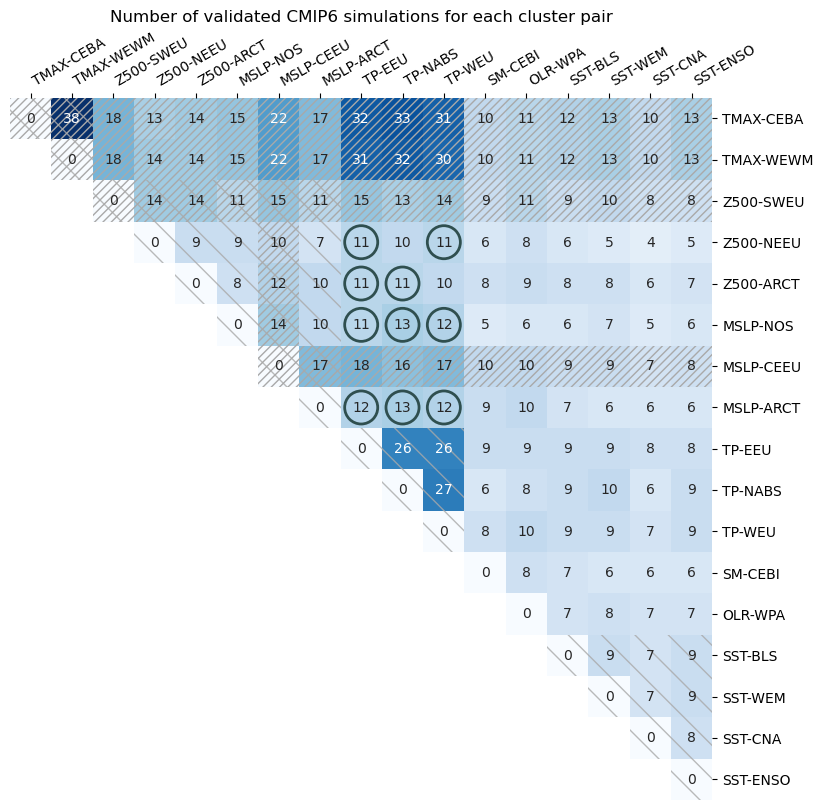

In [23]:
funsl.heatmap_pairs_table_v2(pairs_table_or, on_site, min_pop_pair)


## \\ hatches: Correlated variables
## // hatches: On-site variables

In [37]:
top_pairs = funsl.identify_validated_pairs_list(pairs_table_or, on_site, replace_cl_names, min_pop_pair)

## Readable top pairs
top_pairs_acronyms = top_pairs.copy()
top_pairs_acronyms['driver1'] = top_pairs_acronyms['driver1'].replace(replace_cl_names)
top_pairs_acronyms['driver2'] = top_pairs_acronyms['driver2'].replace(replace_cl_names)

In [40]:
top_pairs_acronyms

,driver1,driver2,counts
0,MSLP-ARCT,TP-NABS,13
1,MSLP-NOS,TP-NABS,13
2,MSLP-ARCT,TP-WEU,12
3,MSLP-ARCT,TP-EEU,12
4,MSLP-NOS,TP-WEU,12
5,Z500-ARCT,TP-EEU,11
6,Z500-ARCT,TP-NABS,11
7,MSLP-NOS,TP-EEU,11
8,Z500-NEEU,TP-EEU,11
9,Z500-NEEU,TP-WEU,11


### CONSTRUCT A STORYLINE: PROVIDE AN INDEX FROM THE DATAFRAME ABOVE

In [73]:
num_sl = 0
pair = top_pairs.iloc[num_sl].values[0:2]

In [62]:
pair

array(['psl_World_cllow03', 'pr_Europe_cllow02'], dtype=object)

In [63]:
importlib.reload(funsl)

<module 'function_storylines' from '/home/b/b382649/FAILED-OWL/owl/function_storylines.py'>

In [64]:
### INSPECT STATISTICS TO BE USED FOR THE STORYLINES

board_sel = board_df.filter(regex='^' + '|'.join(pair)).dropna() ##choose columns related to the predictors
selrate_sel = selrate_df.filter(regex='^' + '|'.join(pair)).dropna()
first_stat_sel_df,first_selected_predictor = funsl.identify_statistics(pair[0], board_sel, selrate_sel, thre_CMIP6_sel, thre_CMIP6_low) ## identify statistic to use and models that are fit for it
second_stat_sel_df,second_selected_predictor = funsl.identify_statistics(pair[1], board_sel, selrate_sel, thre_CMIP6_sel, thre_CMIP6_low)

In [66]:
first_selected_predictor

'psl_World_cllow03_pc25'

In [67]:
second_selected_predictor

'pr_Europe_cllow02_pc75'

In [78]:
### Which predictors
preds_storyline = [first_selected_predictor , second_selected_predictor] # join them in an array

### Which models
mdls_storyline = list(set(list(first_stat_sel_df.loc[first_stat_sel_df[first_selected_predictor]>thre_CMIP6_low].iloc[:-3].index)) & 
                  set(list(second_stat_sel_df.loc[second_stat_sel_df[second_selected_predictor]>thre_CMIP6_low].iloc[:-3].index))) ## find models that are fit for both

In [86]:
#sl_df = update_sl_df (sl_df, num_sl, sls_exist, preds_storyline, region, months_code, warming) #update storylines df
board_sl = board_df.loc[mdls_storyline,preds_storyline] ## create board for thi storyline
board_sl.to_csv(f'{output_path}sl_mdl_drv_{exp_code_out}_{region}_{months_code}_{CWS_ref}_{str(num_sl).zfill(2)}.csv') ## save board
#sl_df.to_csv(f'storylines_df_{exp_code}_{region}_{months_code}_{warming}.csv',index=False) ## save new version of storylines df
print(' ')
drivers = board_sl.columns.values

In [81]:
### Lag-agreement score related to the selected drivers and models
board_sl

,psl_World_cllow03_pc25,pr_Europe_cllow02_pc75
UKESM1-0-LL_mmb04_ssp245_CWS142,0.606957,0.368886
UKESM1-0-LL_mmb08_ssp245_CWS142,0.670614,0.542286
EC-Earth3_mmb06_hist_CWS142,0.995529,0.437243
CNRM-CM6-1_mmb01_ssp245_CWS142,0.401471,0.569757
EC-Earth3_mmb01_hist_CWS142,0.5762,0.333357
EC-Earth3_mmb09_hist_CWS142,0.623057,0.994586
EC-Earth3_mmb15_hist_CWS142,0.330057,0.499229
UKESM1-0-LL_mmb03_ssp245_CWS142,0.689243,0.449329
MPI-ESM1-2-HR_mmb01_hist_CWS142,0.390714,0.755429
CMCC-CM2-SR5_mmb02_hist_CWS142,0.428714,0.5669


In [ ]:
### RETRIEVE DATA OF DRIVER SERIES RELATED TO THIS STORYLINE

## Initiate the dataframe
cl_avg = pd.DataFrame(columns = list([f'{w}_{d}' for d in board_sl.columns for w in wmgs]))

for full_name0 in board_sl.index:

    print(full_name0)
    parts = full_name0.split('_')

    model = parts[0]
    member = parts[1]
    ssp0 = parts[2]
    wmg_base = parts[3]
    if ssp0 == 'hist':
        ssps = CWS_models.loc[CWS_models.extended_name == f'{model}_{member}','ssp'].values
    else:
        ssps = [ssp0]

    if full_name0 == 'ACCESS-CM2_mmb01_ssp126_CWS142':
        ssps = ['ssp126','ssp585']
    if full_name0 == 'ACCESS-CM2_mmb01_ssp245_CWS142':
        ssps = ['ssp245','ssp370']
    #dr = 'tos_North_Atlantic_cllow02_mean'
    print(ssps)
    ssp = 'ssp245'
 

    for ssp in ssps:

        full_name = f'{model}_{member}_{ssp}'
        if (ssp0=='hist') & (full_name in exception_fullnames):
            #print('self-standing ssp')
            continue
            
        print(full_name)
        row = pd.DataFrame(columns=cl_avg.columns, index=[full_name])
        if full_name not in cl_avg.index:
            cl_avg = pd.concat([cl_avg, row], axis=0)
        dr = drivers[1]   

        for dr in drivers:
            #print(dr)
            stat = dr.rsplit('_', 1)[-1]
            cl_string = dr[:-len(stat)-1].rsplit('_', 1)[-1]
            cl = int(cl_string[-2:])
            var_CMIP6 = dr.split('_')[0]
            domain = '_'.join(dr.split('_')[1:-2])   
                
            data = pd.read_csv(f'{series_path}{model}_{member}_{ssp}_CWS_{var_CMIP6}_{exp_code_in}low_time_series.csv')
            #data['date'] = pd.to_datetime(data['date'])
            dr_ser = data[['date',dr]]

            #wmg = wmgs[1]
            for wmg in wmgs:    
                #print(f'Checking warming {wmg}')
                period_start = CWS_models.loc[CWS_models.full_name == full_name, f'{wmg}_start'].values[0]
                period_stop  = CWS_models.loc[CWS_models.full_name == full_name, f'{wmg}_stop'].values[0]

                if (not np.isnan(period_start)) & (not np.isnan(period_stop)):
                    years_list = dr_ser['date'].str[:4].astype(int)
                    mask_period = (years_list >= period_start) & (years_list <= period_stop)
                    sub_ser = dr_ser[mask_period]
                    #avg_dr = np.round(np.mean(sub_ser[dr]),decimals=2)
                    avg_dr = np.mean(sub_ser[dr])
                    cl_avg.loc[full_name,f'{wmg}_{dr}'] = avg_dr
                    # print(f'{full_name} {wmg} {dr} {avg_dr}')
                #else:
                    # print(f'{full_name} {wmg} NOT REACHED')

In [96]:
### How do the drivers change between CWS142 and CWS15?
cl_avg

,CWS142_psl_World_cllow03_pc25,CWS15_psl_World_cllow03_pc25,CWS142_pr_Europe_cllow02_pc75,CWS15_pr_Europe_cllow02_pc75
UKESM1-0-LL_mmb04_ssp245,-467.270606,-520.247479,0.0,0.0
UKESM1-0-LL_mmb08_ssp245,-462.730938,-528.698474,0.0,0.0
EC-Earth3_mmb06_ssp126,-529.139769,-568.951998,0.000001,0.000002
EC-Earth3_mmb06_ssp245,-529.139769,-553.120809,0.000001,0.000002
EC-Earth3_mmb06_ssp370,-529.139769,-534.164918,0.000001,0.000002
CNRM-CM6-1_mmb01_ssp245,-529.940794,-523.828526,0.000002,0.000002
EC-Earth3_mmb01_ssp126,-537.520588,-577.233863,0.000001,0.000002
EC-Earth3_mmb01_ssp245,-537.520588,-591.677682,0.000001,0.000002
EC-Earth3_mmb01_ssp370,-537.520588,-602.445005,0.000001,0.000001
EC-Earth3_mmb01_ssp585,-537.520588,-613.492402,0.000001,0.000002


In [99]:
### Calculate differences model by model

diff_avg = pd.DataFrame({
    f'{CWS_warm}-{CWS_ref}_{drivers[0]}': cl_avg[f'{CWS_warm}_{drivers[0]}'] - cl_avg[f'{CWS_ref}_{drivers[0]}'],
    f'{CWS_warm}-{CWS_ref}_{drivers[1]}': cl_avg[f'{CWS_warm}_{drivers[1]}'] - cl_avg[f'{CWS_ref}_{drivers[1]}']
})
diff_avg = diff_avg.dropna().sort_index()

In [100]:
diff_avg

,CWS15-CWS142_psl_World_cllow03_pc25,CWS15-CWS142_pr_Europe_cllow02_pc75
ACCESS-CM2_mmb01_ssp245,-92.551857,0.0
ACCESS-CM2_mmb01_ssp370,-115.742225,0.0
CMCC-CM2-SR5_mmb02_ssp245,-12.855017,-0.0
CNRM-CM6-1_mmb01_ssp245,6.112268,-0.0
EC-Earth3_mmb01_ssp126,-39.713276,0.0
EC-Earth3_mmb01_ssp245,-54.157095,0.0
EC-Earth3_mmb01_ssp370,-64.924417,0.0
EC-Earth3_mmb01_ssp585,-75.971814,0.0
EC-Earth3_mmb06_ssp126,-39.812229,0.0
EC-Earth3_mmb06_ssp245,-23.98104,0.0
